In [1]:
!unzip "/content/train.csv.zip" -d "/content/"

Archive:  /content/train.csv.zip
  inflating: /content/train.csv      


In [80]:
#importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt



##dataset descriptions
### data consists of 4 columns:

#####1.date : consists of sales date without holiday or weekend considerations
#####2.store : store id/num of each store
#####3.item : item id/num available for sales
#####4. sales: no of sales corresponding to each store and item



In [148]:
#reading the data
df=pd.read_csv('/content/inventory_data.csv',parse_dates=['date'])
df.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


###BASIC EDA(Exploratory data Analysis)

In [82]:
#printing shape of the data
df.shape

(913000, 4)

In [83]:
#Five point summary of the dataset
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [84]:
#checking for the missing values
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

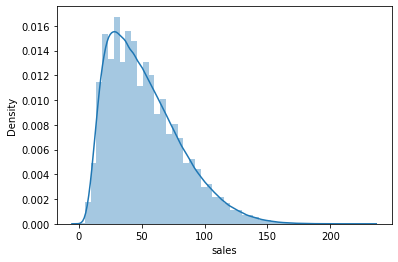

In [85]:
#checking sales distribution
sb.distplot(df.sales)

##Observation 
it looks like sales follows a log normal disribution

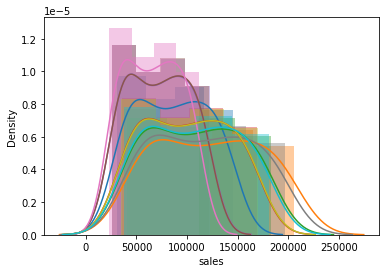

In [86]:

#checking distribution of item sales for each store
import warnings
warnings.filterwarnings('ignore')
for i in range(len(df['store'].unique())):
  tmp=df[df['store']==i+1].groupby(['item'])['sales'].sum()
  sb.distplot(tmp)

**distribution of item sales per store id follows more or less same pattern but sales value range is different for different store**
####it makes more sense to train a different model for each store. This way we also reduce number of dimensions and sparse data representation in the dataset that is going as final input in the model for training

In [149]:
#Fearure Engineering
#since we have a date column we can extract useful information like day of the week, month of the year etc
#which will be useful in prediction of th sales 
df['month'] = df.date.dt.month # month of the year
df['day_of_month'] = df.date.dt.day # day of the month
df['day_of_year'] = df.date.dt.dayofyear # day of the year
df['week_of_year'] = df.date.dt.weekofyear # week of year
df['day_of_week'] = df.date.dt.dayofweek # day of the week of the each month
df['year'] = df.date.dt.year # year
df["is_wknd"] = df.date.dt.weekday//4 # is it a weekday or weekend //4 gives 0 for mon to fri else give 1 
df['is_month_start'] = df.date.dt.is_month_start.astype(int) #is it month start?
df['is_month_end'] = df.date.dt.is_month_end.astype(int)     # is it month end?

In [150]:
df.info() #checking df after adding new feature columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            913000 non-null  datetime64[ns]
 1   store           913000 non-null  int64         
 2   item            913000 non-null  int64         
 3   sales           913000 non-null  int64         
 4   month           913000 non-null  int64         
 5   day_of_month    913000 non-null  int64         
 6   day_of_year     913000 non-null  int64         
 7   week_of_year    913000 non-null  int64         
 8   day_of_week     913000 non-null  int64         
 9   year            913000 non-null  int64         
 10  is_wknd         913000 non-null  int64         
 11  is_month_start  913000 non-null  int64         
 12  is_month_end    913000 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 90.6 MB


In [151]:
#doing hotencoding for the categorical variables in
df = pd.get_dummies(df, columns=['item', 'day_of_week', 'month'])
df.head()

,date,store,sales,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,1,13,1,1,1,2013,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,1,11,2,2,1,2013,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,1,14,3,3,1,2013,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,1,13,4,4,1,2013,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,1,10,5,5,1,2013,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [153]:
#year wise distribution for the time based splitting and training
df.year.value_counts()

2016    183000
2017    182500
2015    182500
2014    182500
2013    182500
Name: year, dtype: int64

In [93]:
#since sales data distribution seems like log normal we can consider taking log transformation to normalize the data 
df['sales'] = np.log1p(df["sales"].values)

<br><br>
##I am training models for the store 2 only for the sake of training time involved in deeplearning and gradientboosting models
<br><br>
**Gradientboosting is choosen because it tends to perform better compare to other classical ml algorithms for the high dimension and sparse dataset(due to hot-encoding applied on the categorical variable)** 

In [105]:
#taking 2017 data for the testing and remaining for the training (doing time based splitting)
data_test=df[(df['store']==2) & (df['year']==2017)]
data_train=df[(df['store']==2) & (df['year'] != 2017)]
data_train.year.unique()

array([2013, 2014, 2015, 2016])

In [106]:
data_test.year.unique() #verifying the timebased split

array([2017])

In [108]:
#selecting columns for training and testing
cols = [col for col in df.columns if col not in ['store','date', 'id', "sales", "year"]]
x_train=data_train[cols]
x_test=data_test[cols]
y_train=data_train['sales']
y_test=data_test['sales']


In [113]:
#using gradient boosting algorithm
from sklearn.ensemble import GradientBoostingRegressor

In [114]:
#training the model
reg = GradientBoostingRegressor(random_state=0)
reg.fit(x_train, y_train)

GradientBoostingRegressor(random_state=0)

In [115]:
#predicting the sales
y_pred=reg.predict(x_test)

In [116]:
#calculating mean abslute error
mae = sum(np.abs(y_pred - y_test))/len(y_test)
mae

0.2401591402112335

In [118]:
#calculating mean absolute percentage error
(sum(np.abs((y_test-y_pred)/y_test))/len(y_test))*100

5.552289902891808

## Trying Deep Learning approach,Training a basic neural network from scratch


In [120]:
#importing libraries for deeplearning
import tensorflow
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout

In [121]:
model=Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(8,activation="relu"))
model.add(Dense(4,activation="relu"))
model.add(Dense(1,activation="linear"))

In [122]:
model.compile(loss="mean_absolute_percentage_error",optimizer="adam")

In [123]:
model.fit(x_train,y_train,epochs=50,batch_size=8)

Epoch 1/50
9132/9132 [==============================] - 16s 2ms/step - loss: 6.8369
Epoch 2/50
9132/9132 [==============================] - 16s 2ms/step - loss: 4.5596
Epoch 3/50
9132/9132 [==============================] - 16s 2ms/step - loss: 4.4222
Epoch 4/50
9132/9132 [==============================] - 16s 2ms/step - loss: 4.2709
Epoch 5/50
9132/9132 [==============================] - 16s 2ms/step - loss: 4.2279
Epoch 6/50
9132/9132 [==============================] - 16s 2ms/step - loss: 4.0556
Epoch 7/50
9132/9132 [==============================] - 15s 2ms/step - loss: 4.0284
Epoch 8/50
9132/9132 [==============================] - 15s 2ms/step - loss: 3.9502
Epoch 9/50
9132/9132 [==============================] - 15s 2ms/step - loss: 3.9228
Epoch 10/50
9132/9132 [==============================] - 16s 2ms/step - loss: 3.8664
Epoch 11/50
9132/9132 [==============================] - 15s 2ms/step - loss: 3.8611
Epoch 12/50
9132/9132 [==============================] - 16s 2ms/step - lo

In [130]:
#predicting using model
y_pred=model.predict(x_test)
mae= sum(np.abs(y_pred.ravel() - y_test))/len(y_test)
mae

0.1478613822461597

In [137]:

#calculating mean absolute percentage error
(sum(np.abs((y_test-y_pred.ravel())/y_test))/len(y_test))*100

3.5727928188044955

#Deeplearning performs better compare to Gradientboosting Regression model here